100%|███████████████████████████████████████████████████████████████████████████████| 497/497 [00:00<00:00, 632.81it/s]


Accuracy on train set:  0.964
Accuracy on dev set:  0.30181086519114686
Accuracy on test set:  0.32007952286282304
F1 train:  0.964
F1 test:  0.32007952286282304
F1 dev:  0.30181086519114686
precision_score train:  0.964
precision_score test:  0.32007952286282304
precision_score dev:  0.30181086519114686
recall_score train:  0.964
recall_score test:  0.32007952286282304
recall_score dev:  0.30181086519114686
Accuracy on train set:  0.974
Accuracy on dev set:  0.3038229376257545
Accuracy on test set:  0.3359840954274354
F1 train:  0.974
F1 test:  0.3359840954274354
F1 dev:  0.3038229376257545
precision_score train:  0.974
precision_score test:  0.3359840954274354
precision_score dev:  0.3038229376257545
recall_score train:  0.974
recall_score test:  0.3359840954274354
recall_score dev:  0.3038229376257545
Accuracy on train set:  0.982
Accuracy on dev set:  0.3118712273641851
Accuracy on test set:  0.3320079522862823
F1 train:  0.982
F1 test:  0.3320079522862823
F1 dev:  0.31187122736418

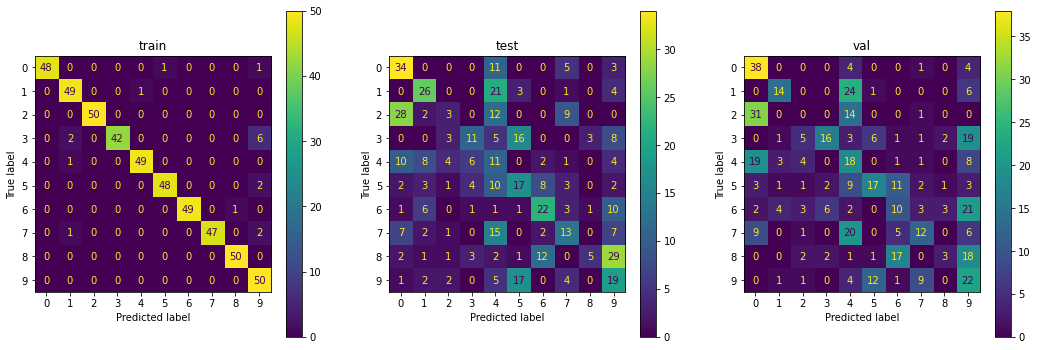

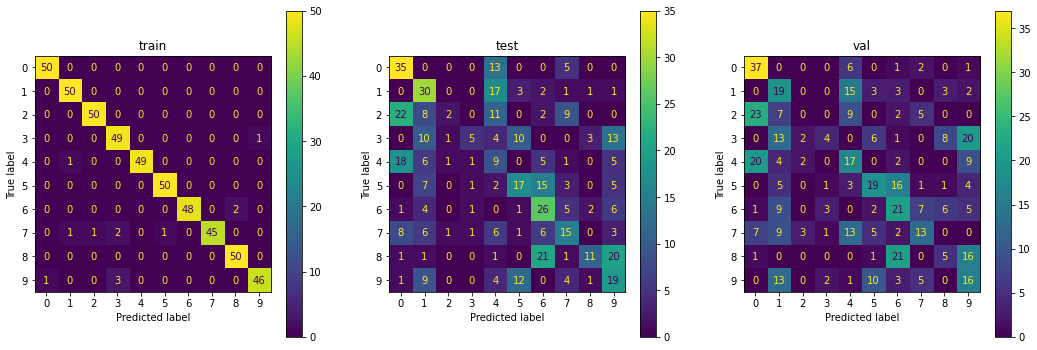

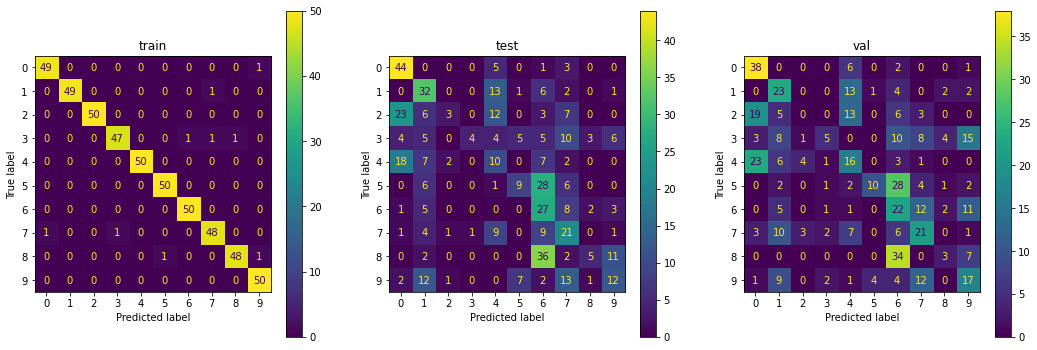

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [1]:
# %matplotlib inline
# add this to ignore warnings from Librosa
import warnings

import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn import preprocessing

warnings.filterwarnings('ignore')

# for linear models

from tqdm import tqdm


def extract_melspectrogram(signal, sr, num_mels):
	"""
	Given a time series speech signal (.wav), sampling rate (sr),
	and the number of mel coefficients, return a mel-scaled
	representation of the signal as numpy array.
	"""

	mel_features = librosa.feature.melspectrogram(y=signal,
	                                              sr=sr,
	                                              n_fft=200,  # with sampling rate = 8000, this corresponds to 25 ms
	                                              hop_length=80,  # with sampling rate = 8000, this corresponds to 10 ms
	                                              n_mels=num_mels,  # number of frequency bins, use either 13 or 39
	                                              fmin=50,  # min frequency threshold
	                                              fmax=4000  # max frequency threshold, set to SAMPLING_RATE/2
	                                              )

	# for numerical stability added this line
	mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

	# 20 * log10 to convert to log scale
	log_mel_features = 20 * np.log10(mel_features)

	# feature scaling
	scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)

	return scaled_log_mel_features


def downsample_spectrogram(X, N):
	time_splits = np.array_split(X, N, axis=1)
	pooled_splits = [np.mean(split, axis=1) for split in time_splits]
	v = np.concatenate(pooled_splits)
	return v


def get_downsampled_data(df):
	signals = df.file.values
	labels = df.label.values
	# This value details is given in TASK 1 parameter N <= 25
	N = 10

	signals1 = []
	for file in df.file.values:
		signal1, sr = librosa.load(file)
		signals1.append(signal1)

	S = []
	for s in tqdm(signals1):
		S.append(downsample_spectrogram(extract_melspectrogram(s, sr=8000, num_mels=13), N))
	return S, labels


if __name__ == '__main__':
	data = pd.read_csv('SDR_metadata.tsv', sep='\t')

	train_data = data[data.split == "TRAIN"]
	dev_data = data[data.split == "DEV"]
	test_data = data[data.split == "TEST"]

	# condition the train data on only one speaker
	train_data = train_data[train_data['speaker'] == 'george']

	downsampled_train, train_labels = get_downsampled_data(train_data)
	downsampled_test, test_labels = get_downsampled_data(test_data)
	downsampled_dev, dev_labels = get_downsampled_data(dev_data)


	from sklearn.linear_model import SGDClassifier

	clf_mlp = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
	clf_svm = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000,
	                    tol=0.001)
	clf_lr = SGDClassifier(loss='log', alpha=0.001, max_iter=1000, tol=1e-3, random_state=42)

	for clf, t in [(clf_mlp, 'MLP'), (clf_svm, 'SVM'), (clf_lr, 'LR')]:

		clf.fit(downsampled_train, train_labels)

		accuracy = clf.score(downsampled_train, train_labels)
		print("Accuracy on train set: ", accuracy)

		accuracy = clf.score(downsampled_dev, dev_labels)
		print("Accuracy on dev set: ", accuracy)

		accuracy = clf.score(downsampled_test, test_labels)
		print("Accuracy on test set: ", accuracy)

		from sklearn.metrics import f1_score, precision_score, recall_score
		train_predictions = clf.predict(downsampled_train)
		test_predictions = clf.predict(downsampled_test)
		dev_predictions = clf.predict(downsampled_dev)
		train_f1 = f1_score(train_labels, train_predictions, average='micro')
		test_f1 = f1_score(test_labels, test_predictions, average='micro')
		dev_f1 = f1_score(dev_labels, dev_predictions, average='micro')
		print("F1 train: ", train_f1)
		print("F1 test: ", test_f1)
		print("F1 dev: ", dev_f1)
		# precision
		train_f1 = precision_score(train_labels, train_predictions, average='micro')
		test_f1 = precision_score(test_labels, test_predictions, average='micro')
		dev_f1 = precision_score(dev_labels, dev_predictions, average='micro')
		print("precision_score train: ", train_f1)
		print("precision_score test: ", test_f1)
		print("precision_score dev: ", dev_f1)
		# recall
		train_f1 = recall_score(train_labels, train_predictions, average='micro')
		test_f1 = recall_score(test_labels, test_predictions, average='micro')
		dev_f1 = recall_score(dev_labels, dev_predictions, average='micro')
		print("recall_score train: ", train_f1)
		print("recall_score test: ", test_f1)
		print("recall_score dev: ", dev_f1)

		# create the confusion matrix
		from sklearn.metrics import ConfusionMatrixDisplay
		from sklearn.metrics import confusion_matrix

		import matplotlib.pyplot as plt

		matrix_train = confusion_matrix(y_true=train_labels, y_pred=train_predictions)
		matrix_test = confusion_matrix(y_true=test_labels, y_pred=test_predictions)
		matrix_val = confusion_matrix(y_true=dev_labels, y_pred=dev_predictions)

		fig, ax = plt.subplots(1, 3, figsize=(18, 6))

		ax[0].set_title('train')
		ax[1].set_title('test')
		ax[2].set_title('val')

		ConfusionMatrixDisplay(matrix_train).plot(ax=ax[0])
		ConfusionMatrixDisplay(matrix_test).plot(ax=ax[1])
		ConfusionMatrixDisplay(matrix_val).plot(ax=ax[2])

		fig.savefig(f'./confusion_matrix_single_speaker{t}.png', dpi=300)
		plt.plot()